In [20]:
## Importing Libraries ## 
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from IPython.display import Markdown as md
import warnings
warnings.filterwarnings('ignore')
# %matplotlib inline
from scipy.optimize import minimize
import time

In [21]:
## This cell defines our Poission Process, Customer, and Customer List Classes ##

#############################
class PoissonProcess():
    def __init__(self, lam, T):
        self.lam = lam
        self.T = T
        self.simulate()

        
    def simulate(self, method='inter_arrival_time'):
        if method == 'inter_arrival_time':
            N = int(self.lam * self.T * 1.3)
            inter_ls = np.random.exponential(1/self.lam, size=N)
            arrival_time_ls = np.cumsum(inter_ls)
            self.arrival_time_ls = arrival_time_ls[arrival_time_ls <= self.T]
        if method == 'uniformity_property':
            N = np.random.poisson(self.T * self.lam)
            arrival_time_ls = np.random.uniform(0, self.T, size=N)
            self.arrival_time_ls = np.sort(arrival_time_ls)

            
    def get_arrival_time(self):
        return self.arrival_time_ls

    
    def print_parameter(self):
        print('lambda = {}, T = {}'.format(self.lam, self.T))

        
    def N_t(self, t):
        assert t >= 0
        assert t <= self.T
        if t == 0:
            return 0
        else:
            return np.argmax(self.arrival_time_ls > t)

        
    def plot_N_t(self, color='r',alpha=1):
        positive_inf = max(self.arrival_time_ls) * 1.2
        negative_inf = - max(self.arrival_time_ls) * 0.1
        n_arrival = len(self.arrival_time_ls)
        x_ls = np.concatenate([[negative_inf, 0], np.repeat(self.arrival_time_ls,2), [positive_inf]])
        y_ls = np.concatenate([[0], np.repeat(np.arange(n_arrival + 1),2)])
        plt.plot(x_ls, y_ls, c=color, alpha=alpha)        

#############################        
class Customer():
    def __init__(self, arrival_time=0, ctype='normal',wait_time=None):
        self.arrival_time = arrival_time
        self.ctype = ctype
        self.wait_time = wait_time
        
        
    def abandon_prob(self,prev_cust_wait):
        
        abandon_probs = {"<40":.005, ">=40<50":0.015, ">=50<60":0.03, ">=60<75":0.08, ">=75<90":0.1,
                         ">=90<105":0.1, ">=105<120":0.1, ">=120<180":0.1, ">=180":0.15,
                        }
        ### 170 is <<< 1800 so so our approximation the people in the line is okay
        if prev_cust_wait == 0:
            abandon_prob = 0
        elif prev_cust_wait<(40/60):
            abandon_prob = abandon_probs["<40"]
        elif prev_cust_wait>=(40/60) and prev_cust_wait<(50/60):
            abandon_prob = abandon_probs[">=40<50"]
        elif prev_cust_wait>=(50/60) and prev_cust_wait<(60/60):
            abandon_prob = abandon_probs[">=50<60"]
        elif prev_cust_wait>=(60/60) and prev_cust_wait<(75/60):
            abandon_prob = abandon_probs[">=60<75"]
        elif prev_cust_wait>=(75/60) and prev_cust_wait<(90/60):
            abandon_prob = abandon_probs[">=75<90"]
        elif prev_cust_wait>=(90/60) and prev_cust_wait<(105/60):
            abandon_prob = abandon_probs[">=90<105"]    
        elif prev_cust_wait>=(105/60) and prev_cust_wait<(120/60):
            abandon_prob = abandon_probs[">=105<120"]  
        elif prev_cust_wait>=(120/60) and prev_cust_wait<(180/60):
            abandon_prob = abandon_probs[">=120<180"]
        elif prev_cust_wait>=(180/60):
            abandon_prob = abandon_probs[">=180"]
            
        return abandon_prob
    
    
#############################
class Customer_ls():
    empty = ()

    def __init__(self, customer_ls=np.array([])):
        self.customer_ls = np.array(customer_ls)
        self.customer_ls = self.customer_ls[np.argsort([customer.arrival_time for customer in customer_ls])]
        self.next = None if not customer_ls else self.customer_ls[0]

        
    def __len__(self):
        return len(self.customer_ls)
        
        
    def next_exits(self):
        if len(self)==1:
            next_cust, self.customer_ls = self.customer_ls[0], np.array([])
            self.next = None
        else:
            next_cust, self.customer_ls = self.customer_ls[0], self.customer_ls[1:]
            self.next = self.customer_ls[0]
        return next_cust
    
    
    def add_to_sort(self, customer):
        self.customer_ls = np.append(self.customer_ls, customer)
        self.customer_ls = self.customer_ls[np.argsort([customer.arrival_time for customer in self.customer_ls])]
        self.next = self.customer_ls[0]
    
    
    def add_to_nosort(self, customer):
        self.customer_ls = np.append(self.customer_ls, customer)
        self.next = self.customer_ls[0]
    
    
    def sort(self):
        self.customer_ls = self.customer_ls[np.argsort([customer.arrival_time for customer in self.customer_ls])]
        self.next = self.customer_ls[0]
        

#############################

___

## Model #3

In [22]:
## Loading Speed Factor Function ## 
def speed_factor(proportion_express): 
    factor = -0.5*proportion_express + 1

        #factor = 1 - 0.8*np.sqrt(proportion_express)
    return factor

In [272]:
## ONE DAY FUNCTION FOR MODEL #3 ##

## The cell contains a function to simulate a single day of the queueing system ##

def one_day_express(arrival_ls, express_prop, express_abandon_prob, ExpressPriority = 1.0):
    
    #### FOR TUNING ####
    ExpressPriority = 1.0
#     express_prop = 0.15
#     express_abandon_prob = 0.15
    ####################
    
    customer_arrivals = [Customer(arr) for arr in arrival_ls]
    customer_arrivals = Customer_ls(customer_arrivals)

    NormalQueue, ExpressQueue, cust_output= Customer_ls(), Customer_ls(), Customer_ls()
    
    switched_11, switched_1 = False, False
    capacity_8, capacity_11, capacity_1 = 136, 170, 204
    train_capacity = capacity_8
    
    train_finish_time, prev_wait_time = 0, 0
    time = 0
    while len(customer_arrivals) > 0 or len(NormalQueue) > 0 or len(ExpressQueue) > 0:

        next_arr = customer_arrivals.next
        
        ## FIRST CAR DOESN"T LEAVE TILL FULL ##
        if train_finish_time == 0 and len(NormalQueue)<train_capacity:
            if np.random.binomial(n=1,p=express_prop):
                new_arrival = customer_arrivals.next_exits()
                new_arrival.arrival_time += np.random.uniform(0.5,1.5)
                new_arrival.ctype = "express"
                customer_arrivals.add_to_sort(new_arrival)
            else:
                new_arrival = customer_arrivals.next_exits()
                NormalQueue.add_to_nosort(new_arrival)
            
            if len(NormalQueue)==train_capacity:
                train_finish_time = NormalQueue.customer_ls[-1].arrival_time
        
        ## ARRIVAL TO SYSTEM ##
        elif len(customer_arrivals)>0 and (len(NormalQueue)+len(ExpressQueue)==0 or next_arr.arrival_time<train_finish_time):
            
            if next_arr.arrival_time>time:
                customer_arrivals.sort()
                time+=0.4
                next_arr = customer_arrivals.next
            
            ## EXPRESS ARRIVAL
            if next_arr.ctype == "express":
                new_arrival = customer_arrivals.next_exits()
                ExpressQueue.add_to_nosort(new_arrival)
            
            ## NORMAL ARRIVAL ##
            elif next_arr.ctype == "normal":
                if next_arr.arrival_time <= 10.5 and np.random.binomial(n=1,p=express_prop):
                    new_arrival = customer_arrivals.next_exits()
                    new_arrival.arrival_time += np.random.uniform(0.5,1.5)
                    new_arrival.ctype = "express"
                    customer_arrivals.add_to_nosort(new_arrival)
                else:
                    new_arrival = customer_arrivals.next_exits()
                    NormalQueue.add_to_nosort(new_arrival)
        
        ## SEND A TRAIN ##
        else:
            if train_finish_time > 3 and not switched_11: 
                train_capacity = capacity_11
                switched_11 = True
            elif train_finish_time > 5 and not switched_1:
                train_capacity = capacity_1
                switched_1 = True
                
            train_max = min(train_capacity,len(NormalQueue)+len(ExpressQueue))
            rider_types = np.array([])
                
            train_count = 0
            last_abandon = False
            load_next = np.random.choice(['express','normal'],p=[ExpressPriority,1-ExpressPriority])
            while train_count < train_max:
                
                ## EXIT IF BOTH QUEUES ARE EMPTY ##
                if len(ExpressQueue)==0 and len(NormalQueue)==0:
                    train_max = train_count
                    
                ## PROCESS THE NEXT CUSTOMER FROM EITHER EXPRESS OR NORMAL ##
                else:
                    load_next = np.random.choice(['express','normal'],p=[ExpressPriority,1-ExpressPriority]) if not(last_abandon) else load_next
                    
                    ## NEXT IS EXPRESS ##
                    if len(ExpressQueue)!=0 and load_next=='express':
                        next_served = ExpressQueue.next_exits()
                        abandon_prob = express_abandon_prob
    
                    ## NEXT IS NORMAL ##
                    elif (len(ExpressQueue)==0 and len(NormalQueue)>0) or (len(NormalQueue)!=0 and load_next=='normal'):
                        next_served = NormalQueue.next_exits()
                        abandon_prob = next_served.abandon_prob(prev_wait_time)
                        
                    ## NO ABANDON ##
                    if np.random.binomial(n=1,p=1-abandon_prob):
                        new_wait_time = max(0,train_finish_time-next_served.arrival_time)
                        next_served.wait_time = new_wait_time
                        cust_output.add_to_nosort(next_served)
                        prev_wait_time = new_wait_time
                        train_count += 1
                        last_abandon=False
                        rider_types = np.append(rider_types, next_served.ctype)
                    
                    ## ABANDON ##
                    else:
                        next_served.wait_time = -999
                        cust_output.add_to_nosort(next_served)
                        last_abandon=True
            
            
            
            ## SPEED FACTOR AND SERVICE TIME ##
            proportion_express = 0 if len(rider_types)==0 else np.count_nonzero(rider_types == 'express') / len(rider_types)
            factor = speed_factor(proportion_express)
            
            load_min, load_max = 0.5/60, 1./60
            unload_min, unload_max = 0.25/60, 0.75/60
            
            load_time = factor * np.random.uniform(load_min, load_max)
            unload_time = np.random.uniform(unload_min, unload_max)
            service_time = load_time + 3./60 + unload_time
            
            train_finish_time = train_finish_time + service_time
    
    return cust_output

In [122]:
from itertools import product
# obtain_list, unused_list = [.05, .1, .15, .2, .25], [.025, .05, .1, .2, .25]
obtain_list, unused_list = [.05, .15, .35], [.05, .15, .35]

output = list(product(obtain_list, unused_list))

In [124]:
df = pd.DataFrame()
for pair in output: 
    
    trials = 5
    df2 = pd.DataFrame()
    for i in range(0, trials): 
        arrival_ls = np.genfromtxt('data/day' + str(i+1) + '_arrivals.csv')[1:]
        customers = one_day_express(arrival_ls, express_prop = pair[0], express_abandon_prob = pair[1]).customer_ls
        
        data = {
        'day' : i*np.ones(len(arrival_ls)).astype(int),
        'Obtain Probability' : np.repeat(pair[0], len(customers)),
        'Unused Probability' : np.repeat(pair[1], len(customers)),
        'Customer Type' : [customer.ctype for customer in customers],
        'wait' : [60*customer.wait_time for customer in customers],} 
        
        df2 = df2.append(pd.DataFrame(data))
    df = df.append(df2)
    df = df[df['wait'] > 0]
    

Day 0 complete
Day 1 complete
Day 2 complete
Day 3 complete
Day 4 complete
Day 0 complete
Day 1 complete
Day 2 complete
Day 3 complete
Day 4 complete
Day 0 complete
Day 1 complete
Day 2 complete
Day 3 complete
Day 4 complete
Day 0 complete
Day 1 complete
Day 2 complete
Day 3 complete
Day 4 complete
Day 0 complete
Day 1 complete
Day 2 complete
Day 3 complete
Day 4 complete
Day 0 complete
Day 1 complete
Day 2 complete
Day 3 complete
Day 4 complete
Day 0 complete
Day 1 complete
Day 2 complete
Day 3 complete
Day 4 complete
Day 0 complete
Day 1 complete
Day 2 complete
Day 3 complete
Day 4 complete
Day 0 complete
Day 1 complete
Day 2 complete
Day 3 complete
Day 4 complete


In [183]:
df_test_obtain = df.groupby(['day', 'Obtain Probability']).mean().drop('Unused Probability', axis = 1).reset_index()
df_test_unused = df.groupby(['day', 'Unused Probability']).mean().drop('Obtain Probability', axis = 1).reset_index()

In [327]:
from scipy import stats
stats.pearsonr(x2a, y2_p1)

(-0.9711219659089175, 1.8069477717028603e-09)

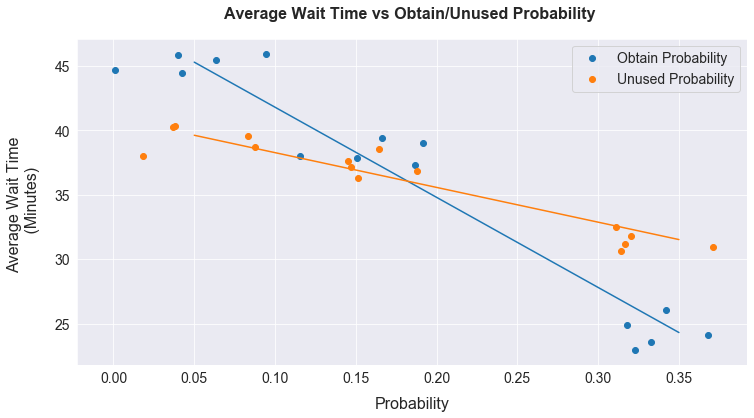

In [397]:
sns.set_style('darkgrid')
fig4a, ax4a = plt.subplots(figsize = (12, 6))

x1a = df_test_obtain['Obtain Probability']
x2a = df_test_unused['Unused Probability']

x1_p1 = df_test_obtain['Obtain Probability'] + np.random.uniform(-0.05, .05, len(df_test_obtain))
y1_p1 = df_test_obtain['wait']

x2_p1 = df_test_unused['Unused Probability'] + np.random.uniform(-0.05, .05, len(df_test_unused))
y2_p1 = df_test_unused['wait']

plt.scatter(x1_p1, y1_p1, label = 'Obtain Probability')
plt.scatter(x2_p1, y2_p1, label = 'Unused Probability')
plt.plot(np.unique(x1a), np.poly1d(np.polyfit(x1a, y1_p1, 1))(np.unique(x1a)))
plt.plot(np.unique(x2a), np.poly1d(np.polyfit(x2a, y2_p1, 1))(np.unique(x2a)))


plt.title('Average Wait Time vs Obtain/Unused Probability ', fontsize = 16, pad = 20, fontweight = 'semibold')
plt.xlabel('Probability', fontsize = 16, labelpad = 10)
plt.ylabel('Average Wait Time \n (Minutes)', fontsize = 16, labelpad = 15)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(prop={'size': 14})
fig4a.savefig('fig4a.pdf')

In [240]:
df_test_obtain_2 = df.groupby(['day', 'Obtain Probability', 'Customer Type']).mean().drop('Unused Probability', axis = 1).reset_index()
df_test_unused_2 = df.groupby(['day', 'Unused Probability', 'Customer Type']).mean().drop('Obtain Probability', axis = 1).reset_index()

In [317]:
a = df_test_obtain_2
b = df_test_unused_2
val_obtain_1 = np.array(a[a['Customer Type'] == 'normal']['wait'].to_list())
val_obtain_2 = np.array(a[a['Customer Type'] == 'express']['wait'].to_list())
val_obtain = val_obtain_1 - val_obtain_2

val_unused_1 = np.array(b[b['Customer Type'] == 'normal']['wait'].to_list())
val_unused_2 = np.array(b[b['Customer Type'] == 'express']['wait'].to_list())
val_unused = val_unused_1 - val_unused_2

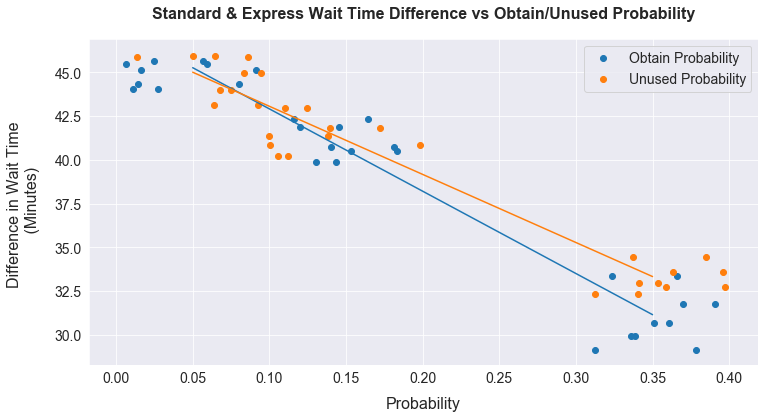

In [396]:
sns.set_style('darkgrid')
fig4b, ax4b = plt.subplots(figsize = (12, 6))

x1a_p2 = a['Obtain Probability']
x2a_p2 = b['Unused Probability']

x1_p2 = a['Obtain Probability'] + np.random.uniform(-0.05, .05, len(a))
y1_p2 = np.repeat(val_obtain, 2)

x2_p2 = b['Unused Probability'] + np.random.uniform(-0.05, .05, len(b))
y2_p2 = np.repeat(val_unused, 2)

plt.scatter(x1_p2, y1_p2, label = 'Obtain Probability')
plt.scatter(x2_p2, y2_p2, label = 'Unused Probability')

plt.plot(np.unique(x1a_p2), np.poly1d(np.polyfit(x1a_p2, y1_p2, 1))(np.unique(x1a_p2)))
plt.plot(np.unique(x1a_p2), np.poly1d(np.polyfit(x1a_p2, y2_p2, 1))(np.unique(x1a_p2)))


plt.title('Standard & Express Wait Time Difference vs Obtain/Unused Probability', fontsize = 16, pad = 20, fontweight = 'semibold')
plt.xlabel('Probability', fontsize = 16, labelpad = 10)
plt.ylabel('Difference in Wait Time \n (Minutes)', fontsize = 16, labelpad = 15)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(prop={'size': 14})
fig4b.savefig('fig4b.pdf')

_____________________________________________________________________________________________________________

In [352]:
df = pd.DataFrame()
for probability in [0.25, 0.45, 0.5, 0.65, 0.75, 0.9, 1]:
    trials = 5
    df2 = pd.DataFrame()
    for i in range(0, trials): 
        arrival_ls = np.genfromtxt('data/day' + str(i+1) + '_arrivals.csv')[1:]
        customers = one_day_express(arrival_ls, express_prop = .15, 
                                    express_abandon_prob = .15,ExpressPriority = probability).customer_ls
        
        data = {
        'day' : i*np.ones(len(arrival_ls)).astype(int),
        'Opening Probability' : np.repeat(probability, len(customers)),
        'Customer Type' : [customer.ctype for customer in customers],
        'wait' : [60*customer.wait_time for customer in customers],} 
        
        df2 = df2.append(pd.DataFrame(data))
        print('Day', i, 'Complete')
    df = df.append(df2)
    df = df[df['wait'] > 0]
    

Day 0 Complete
Day 1 Complete
Day 2 Complete
Day 3 Complete
Day 4 Complete
Day 0 Complete
Day 1 Complete
Day 2 Complete
Day 3 Complete
Day 4 Complete
Day 0 Complete
Day 1 Complete
Day 2 Complete
Day 3 Complete
Day 4 Complete
Day 0 Complete
Day 1 Complete
Day 2 Complete
Day 3 Complete
Day 4 Complete
Day 0 Complete
Day 1 Complete
Day 2 Complete
Day 3 Complete
Day 4 Complete
Day 0 Complete
Day 1 Complete
Day 2 Complete
Day 3 Complete
Day 4 Complete
Day 0 Complete
Day 1 Complete
Day 2 Complete
Day 3 Complete
Day 4 Complete


In [380]:
df_open = df.groupby(['day', 'Opening Probability']).mean().reset_index()
df_test_open = df_open.groupby('Opening Probability').mean()[['wait']].reset_index()
df_standard = df[df['Customer Type'] == 'normal'].groupby('Opening Probability').mean()[['wait']].reset_index()
df_express = df[df['Customer Type'] == 'express'].groupby('Opening Probability').mean()[['wait']]

,day,Opening Probability,wait
24,3,0.65,38.100527
25,3,0.75,38.740807
22,3,0.45,38.741014
5,0,0.90,38.817005
4,0,0.75,38.825012


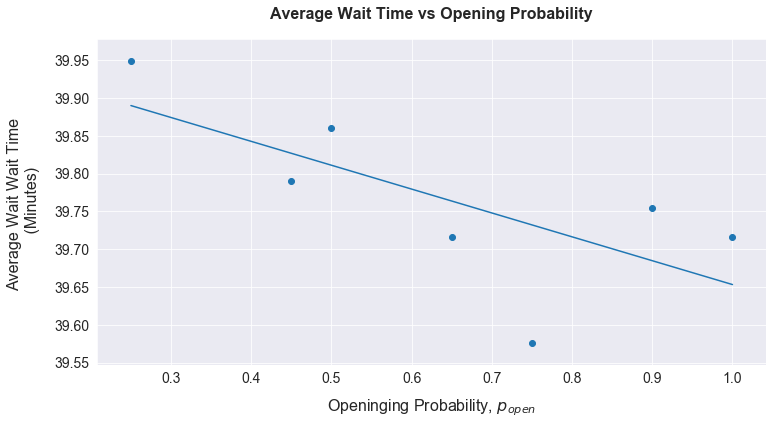

In [415]:
# Plotting Avg Wait Time vs Opening 
sns.set_style('darkgrid')
fig4c, ax4c = plt.subplots(figsize = (12, 6))

xx = df_test_open['Opening Probability'] #+ np.random.uniform(-0.025, .025, len(df_open))
yy = df_test_open['wait']


plt.scatter(xx, yy)
plt.plot(np.unique(xx), np.poly1d(np.polyfit(xx, yy, 1))(np.unique(xx)))


plt.title('Average Wait Time vs Opening Probability', fontsize = 16, pad = 20, fontweight = 'semibold')
plt.xlabel('Openinging Probability, $p_{open}$', fontsize = 16, labelpad = 10)
plt.ylabel('Average Wait Wait Time \n (Minutes)', fontsize = 16, labelpad = 15)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
#plt.legend(prop={'size': 14})
fig4c.savefig('fig4c.pdf')

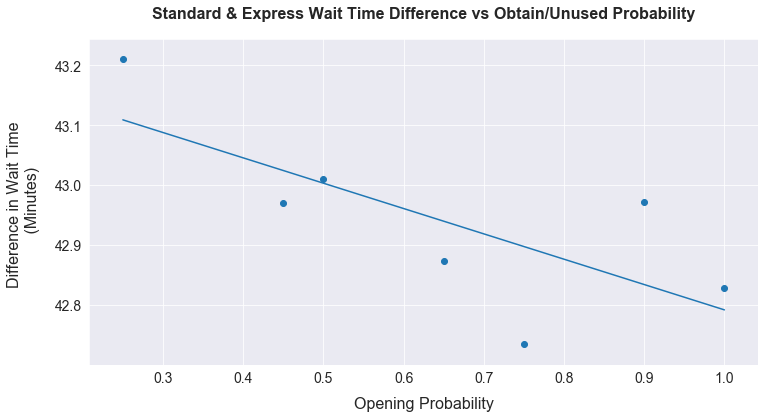

In [414]:
# Plotting Avg Wait Time vs Opening 
sns.set_style('darkgrid')
fig4d, ax4d = plt.subplots(figsize = (12, 6))

xx2 = df_standard['Opening Probability']
yy2 = df_standard['wait'].values - df_express['wait'].values


plt.scatter(xx2, yy2)
plt.plot(np.unique(xx2), np.poly1d(np.polyfit(xx2, yy2, 1))(np.unique(xx2)))


plt.title('Standard & Express Wait Time Difference vs Obtain/Unused Probability', fontsize = 16, pad = 20, fontweight = 'semibold')
plt.xlabel('Opening Probability', fontsize = 16, labelpad = 10)
plt.ylabel('Difference in Wait Time \n (Minutes)', fontsize = 16, labelpad = 15)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
fig4d.savefig('fig4d.pdf')

In [368]:
df_open_2 = df.groupby(['day', 'Opening Probability', 'Customer Type']).mean().reset_index()
df_open_2_normal = df_open_2[df_open_2['Customer Type'] == 'normal'].sort_values('Opening Probability', ascending = True)
df_open_2_express = df_open_2[df_open_2['Customer Type'] == 'express'].sort_values('Opening Probability', ascending = True)
val_open_1 = np.array(df_open_2_normal['wait'].to_list())
val_open_2 = np.array(df_open_2_express['wait'].to_list())
val_open = val_open_1 - val_open_2